In [1]:
description = """
Date: 1/31/2024
Name: 3. SL-Obs-Extract-Fix-Add-Write.ipynb
Purpose: The purpose of this tool is the following:
  1. load in all sightlines into sightline list
  2. load observations
  3. for each sightline:
  4.   for each observation:
  5.     extract the flux and error spectra for sightline from observation
  6.     fix flux and error spectra
  7.     combine flux and error spectra into a single flux and error spectra using ivw
  8.     write out combined flux and error spectra to fits file
"""

In [2]:
# import the world
import sys, os, glob, time
import numpy as np
from pydantic import BaseModel, conlist
from typing import List, Union, Callable, Any, Optional


from kcwitools.io import open_kcwi_cube
from kcwitools.utils import build_wave
from kcwitools import image as im

from linetools.spectra.xspectrum1d import XSpectrum1D  

from astropy.wcs import WCS, FITSFixedWarning
import warnings

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore', category=FITSFixedWarning)

bu_path = '/Users/robertseaton/School/github_repos/CGM-learning/code'
if bu_path not in sys.path:
    sys.path.append(bu_path)
from bobutils import utils as bu, fileio as bio, layout_utils as bl, sightlines as bs, plotutils as bp, observations as bo


In [3]:
wl_nb_min = 4676. 
wl_nb_max = 4696. 
# xs, ys, szs = bs.load_OLD_sightlines()
wl_image, wcs_ref = bio.load_narrowband_reference_image(wl_nb_min, wl_nb_max) 

sightlines = bs.load_231113_sightlines()
sightlines = bs.add_radec_to_sightlines(wcs_ref, sightlines)
for sl in sightlines:
    print(f"{sl}")
    
obs = bio.get_corrected_kcwi_data(wl_nb_min, wl_nb_max)


x=27 y=36 w=3 h=9 color=None radecs=(array([217.47922646, 217.47897812]), array([12.04354425, 12.04427289])) label='1' label_alignment=None srn=None
x=30 y=37 w=3 h=11 color=None radecs=(array([217.47897812, 217.47872977]), array([12.04354425, 12.04443481])) label='2' label_alignment=None srn=None
x=33 y=38 w=3 h=11 color=None radecs=(array([217.47872977, 217.47848142]), array([12.04362521, 12.04451577])) label='3' label_alignment=None srn=None
x=36 y=39 w=3 h=11 color=None radecs=(array([217.47848142, 217.47823308]), array([12.04370617, 12.04459673])) label='4' label_alignment=None srn=None
x=40 y=39 w=5 h=7 color=None radecs=(array([217.47823308, 217.47781916]), array([12.04386809, 12.04443481])) label='5' label_alignment=None srn=None
x=49 y=31 w=11 h=7 color=None radecs=(array([217.47773639, 217.47682578]), array([12.04322041, 12.04378712])) label='6' label_alignment=None srn=None
x=34 y=23 w=11 h=7 color=None radecs=(array([217.47897812, 217.47806751]), array([12.04257273, 12.0431

In [4]:
def create_nb_spec(xspec, nb_min, nb_max):
    """ 
    Creates a narrowband XSpectrum1D object 
    (probably not technically the right name, but it returns back a wavelength-shortened version of the provided xspec) 
    """
    wave = xspec.wavelength.value
    spec = xspec.flux.value
    sig = xspec.sig.value
    
    slices = np.where((wave >= nb_min) & (wave <= nb_max))[0]
    slices = slices[slices < spec.shape[0]]  # Ensure slices are within bounds

    wave_slice = wave[slices]
    spec_slice = spec[slices]
    sig_slice = sig[slices]
    
    return XSpectrum1D.from_tuple((wave_slice, spec_slice, sig_slice)) 

In [5]:
def get_continuum_stats(xspec):
    """ 
    Computes the following continuum stats on the flux and err waveforms:
        stats['flux_med'] = np.median(flux)
        stats['flux_sig'] = np.std(flux)
        stats['err_med'] = np.median(sig)
        stats['err_sig'] = np.std(sig)
        
        stats['SNR_flux'] = np.median(flux) / np.std(flux)
        stats['SNR_sig']  = np.median(sig) / np.std(sig)
    """     

    cont_range = [5003, 5084]
    cont_spec = create_nb_spec(xspec, nb_min=cont_range[0], nb_max=cont_range[1])

    flux = cont_spec.flux.value
    sig = cont_spec.sig.value    
    
    stats={}
    stats['flux_med'] = np.median(flux)
    stats['flux_sig'] = np.std(flux)
    stats['err_med'] = np.median(sig)
    stats['err_sig'] = np.std(sig)
        
    stats['SNR_flux'] = np.median(flux) / np.std(flux)
    stats['SNR_sig'] = np.median(sig) / np.std(sig)
   
    return stats

In [6]:
def fix_xspec(orig_xspec):
    """ fix the error spectrum by scaling it using the SNR of the continuum """
    
    # carve out a continuum
    cont_stats = get_continuum_stats(orig_xspec)
    SNR_flux = cont_stats['SNR_flux'] # np.median(flux) / np.std(flux)
    # print(f"SNR_flux = {SNR_flux}")
    SNR_sig = cont_stats['SNR_sig'] # np.median(sig) / np.std(sig)
    # print(f"SNR_sig = {SNR_sig}")
    factor = SNR_flux / SNR_sig
    # print(f"factor = {factor}")

    # apply the fix to the original spectrum
    new_wave = orig_xspec.wavelength.value
    new_flux = orig_xspec.flux.value
    old_sig = orig_xspec.sig.value

    new_sig = SNR_flux * old_sig

    new_xspec = XSpectrum1D.from_tuple((new_wave, new_flux, new_sig)) 
    
    return new_xspec

In [7]:
def fix_xspec_try2(orig_xspec):
    """ 
    re-scale the error spectrum by using a combination of SNR_flux and SNR_sig 
    SNR_flux = flux_med/flux_sig
    SNR_sig = flux_med/err_med
    factor = SNR_flux/SNR_sig
    """
    
    # the continuum
    cont_stats = get_continuum_stats(orig_xspec)
    SNR_flux = cont_stats['SNR_flux'] # np.median(flux) / np.std(flux)
    # print(f"SNR_flux = {SNR_flux}")
    SNR_sig = cont_stats['SNR_sig'] # np.median(sig) / np.std(sig)
    # print(f"SNR_sig = {SNR_sig}")
    factor = SNR_flux / SNR_sig
    # print(f"factor = {factor}")

    # 4. new_error_spectra = SNR * error_spectra
    new_wave = orig_xspec.wavelength.value
    new_flux = orig_xspec.flux.value
    old_sig = orig_xspec.sig.value

    new_sig = SNR_flux * old_sig

    new_xspec = XSpectrum1D.from_tuple((new_wave, new_flux, new_sig)) 
    
    return new_xspec

In [8]:
# jupyterlab/mac/matplotlib inline craziness
# NOTE: You need the following lines for jupyter lab (commandline) to work on Mac !!!!
# NOTE: and you MUST run this cell twice (I don't know why) to get the image to appear inline
%matplotlib widget 
%matplotlib inline 
import matplotlib
matplotlib.use('TkAgg') 

import matplotlib.pyplot as plt


ax_type: WCSAxes


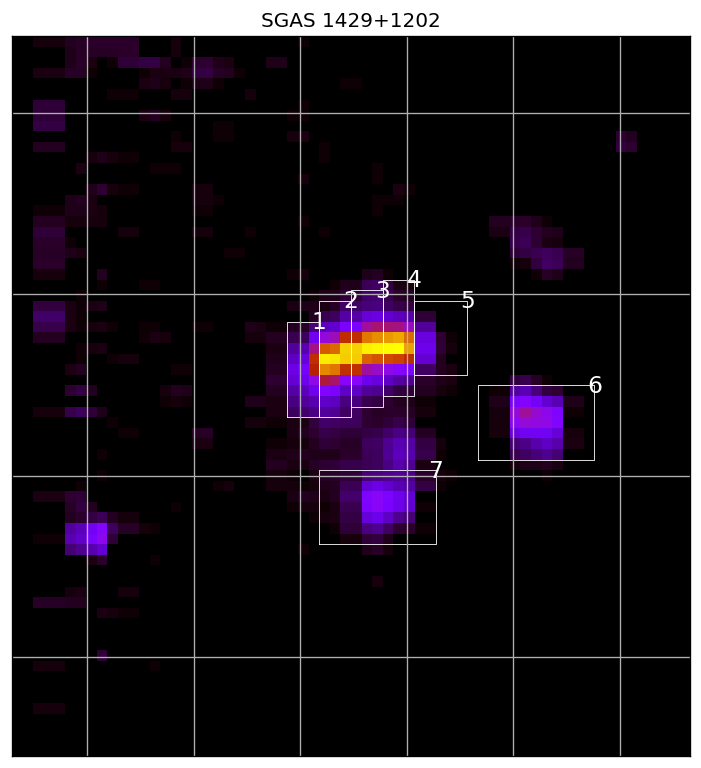

In [9]:
# show white light image and sightlines
plt.close()
fig = plt.figure(figsize=(6,6), dpi=120)
# ax = fig.add_subplot(111, projection=wcs_ref)
ax = fig.add_axes((0,0,1,1), projection=wcs_ref, polar=False)

# sl_of_interest = [sightlines[2]]

bp.show_wl_image(ax, wl_image, title="SGAS 1429+1202")
bp.plot_sightlines_wcs(ax, wcs_ref, sightlines, lw=0.5, show_label=True)

# display(fig.canvas) # cool, interactive canvas in notebook (don't work for me yet)
display(fig) # plots the figure as a static png


In [10]:
description = """ Save to FITS """
output_dir = "/Users/robertseaton/School/github_repos/CGM-learning/code/analysis/J1429+1202_20240131/combined_spectra"

def save_to_fits(sl, xspec):
    base_name = f"{sl.label}_1d_combined_spectra_{sl.x}.{sl.y}-{sl.w}x{sl.h}"
    target_dir = os.path.join(output_dir, base_name)
    if not os.path.exists(target_dir): os.makedirs(target_dir)
    full_pathname = os.path.join(target_dir, base_name + ".fits")
    print(f"writing combined spectrum to {full_pathname}")
    xspec.write_to_fits(full_pathname, clobber=True)



x=27 y=36 w=3 h=9 color=None radecs=(array([217.47922646, 217.47897812]), array([12.04354425, 12.04427289])) label='1' label_alignment=None srn=None
=============== BEGINNING EXTRACTION FOR RA:217.4792264630674 DEC:12.043544250069617 ==================
SQRT the variance for observation 6


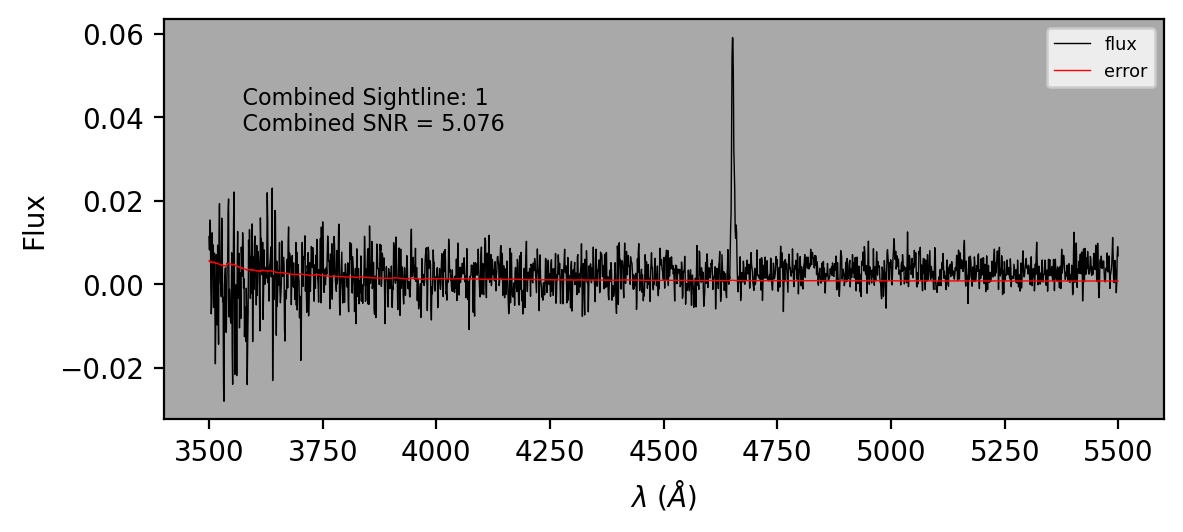


x=30 y=37 w=3 h=11 color=None radecs=(array([217.47897812, 217.47872977]), array([12.04354425, 12.04443481])) label='2' label_alignment=None srn=None
=============== BEGINNING EXTRACTION FOR RA:217.47897811679388 DEC:12.043544250362512 ==================
SQRT the variance for observation 6


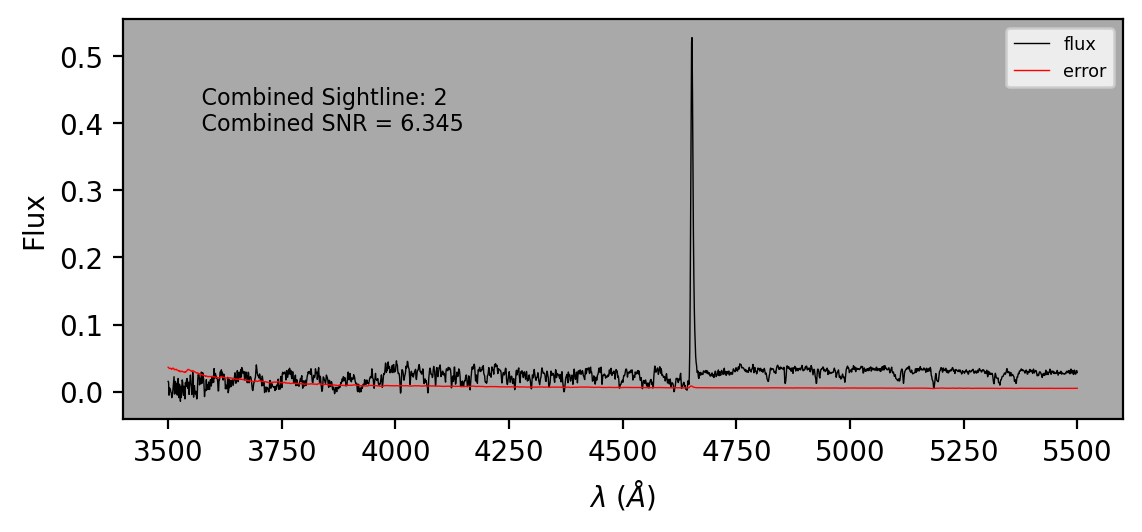


x=33 y=38 w=3 h=11 color=None radecs=(array([217.47872977, 217.47848142]), array([12.04362521, 12.04451577])) label='3' label_alignment=None srn=None
=============== BEGINNING EXTRACTION FOR RA:217.47872977050793 DEC:12.043625210435723 ==================
SQRT the variance for observation 6


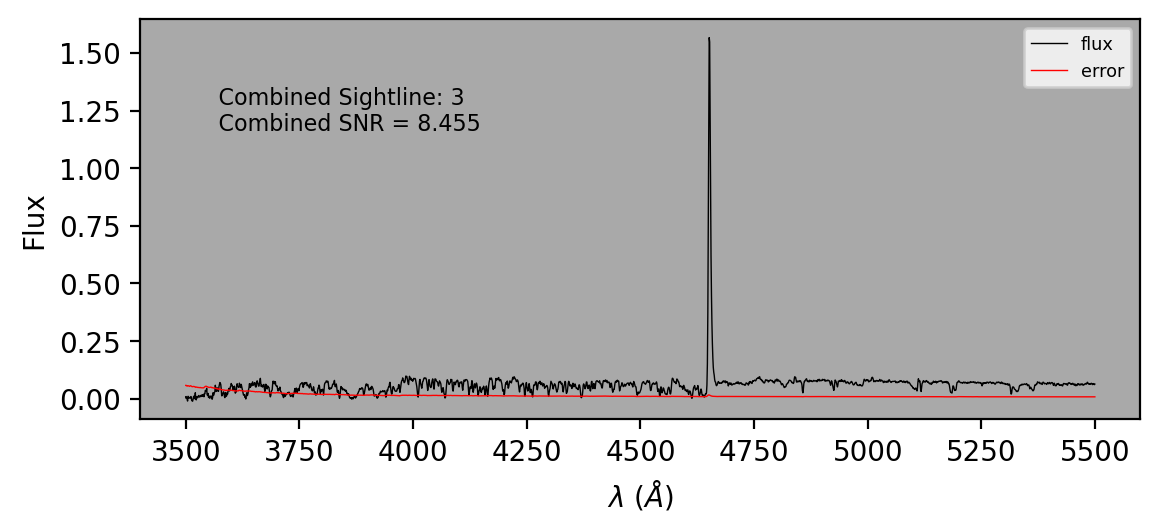


x=36 y=39 w=3 h=11 color=None radecs=(array([217.47848142, 217.47823308]), array([12.04370617, 12.04459673])) label='4' label_alignment=None srn=None
=============== BEGINNING EXTRACTION FOR RA:217.4784814240722 DEC:12.04370617028928 ==================
SQRT the variance for observation 6


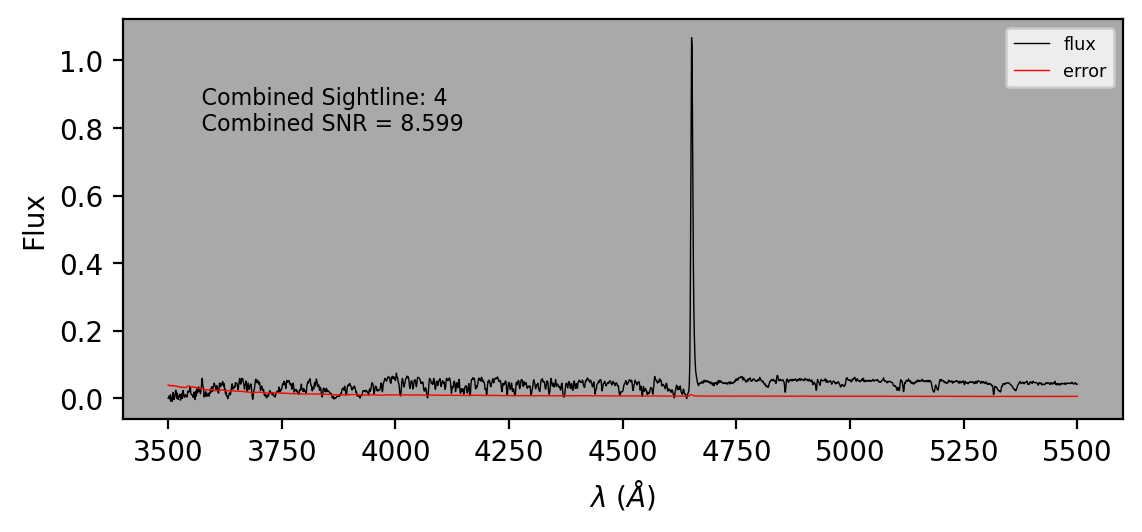


x=40 y=39 w=5 h=7 color=None radecs=(array([217.47823308, 217.47781916]), array([12.04386809, 12.04443481])) label='5' label_alignment=None srn=None
=============== BEGINNING EXTRACTION FOR RA:217.47823307732455 DEC:12.043868089923162 ==================
SQRT the variance for observation 6


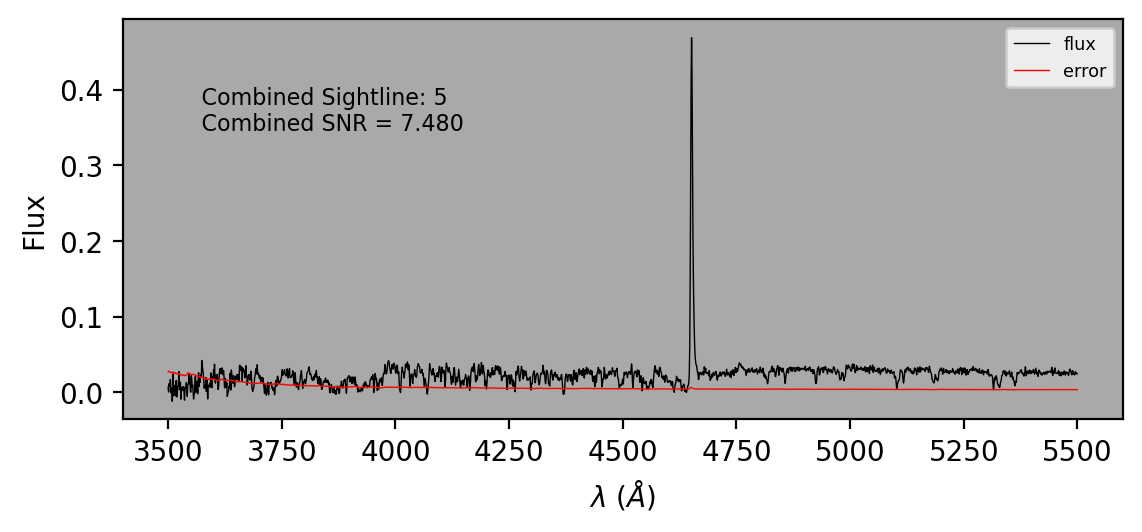


x=49 y=31 w=11 h=7 color=None radecs=(array([217.47773639, 217.47682578]), array([12.04322041, 12.04378712])) label='6' label_alignment=None srn=None
=============== BEGINNING EXTRACTION FOR RA:217.47773638667437 DEC:12.043220408532045 ==================
SQRT the variance for observation 6


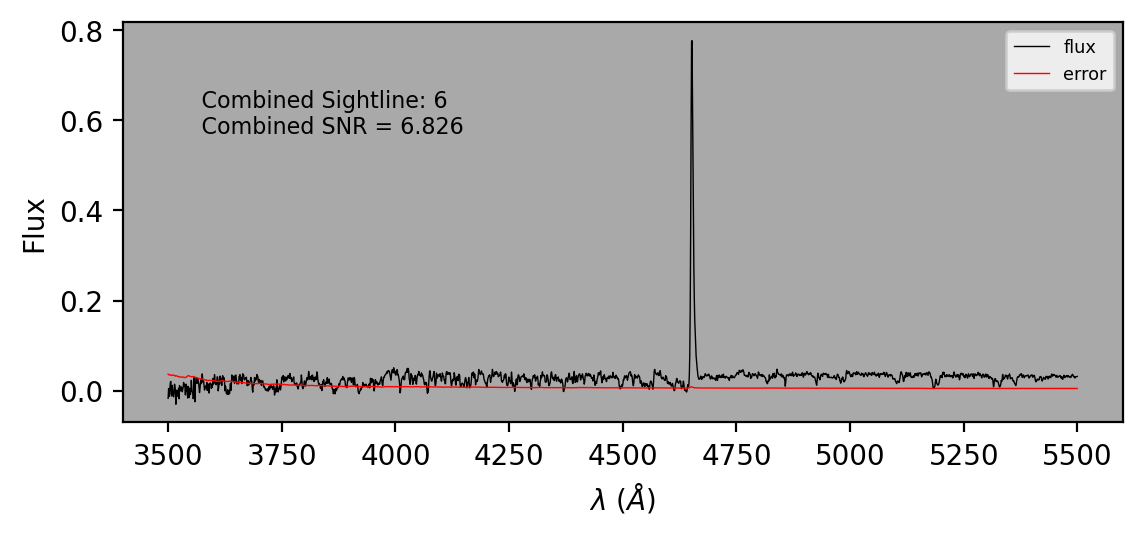


x=34 y=23 w=11 h=7 color=None radecs=(array([217.47897812, 217.47806751]), array([12.04257273, 12.04313945])) label='7' label_alignment=None srn=None
=============== BEGINNING EXTRACTION FOR RA:217.4789781160452 DEC:12.042572730362634 ==================
SQRT the variance for observation 6


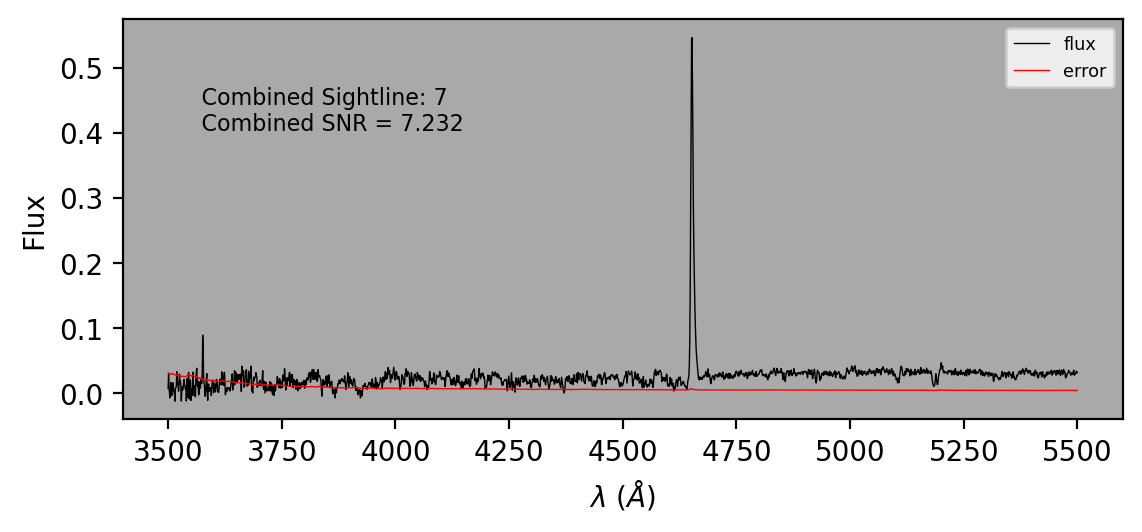

In [11]:
        
for sndx,sl in enumerate(sightlines):
    # if sndx != 0: continue
    print(f"""
{sl}""")
    sl_radec = sl.radecs
    obs_spectra = bo.extract_spectra_from_obs(sl_radec, obs)
    DEBUG = False
    #fix the spectra here
    fixed_obs_spectra = []
    for ondx, ob in enumerate(obs):
        # if ondx != 6 : continue
        if DEBUG: print(f"  observation: {ondx} :: {ob.flux_file}")
        fixed_xspec = fix_xspec(obs_spectra[ondx])
        # bp.plot_spectra(sl, fixed_xspec, label=f"SL: {sl.label} Obs: {ondx}", figsize=(5,1), dpi=200, fontsize=8)        
        fixed_obs_spectra.append(fixed_xspec)
        
    combined_xspec1d = bu.combine_spectra_ivw2(fixed_obs_spectra)  
    new_stats = get_continuum_stats(combined_xspec1d)
    
    if DEBUG:
        print(f"Combined Spec flux_med = {new_stats['flux_med']}")
        print(f"Combined Spec flux_sig = {new_stats['flux_sig']}")
        print(f"Combined Spec err_med = {new_stats['err_med']}")
        print(f"Combined Spec err_sig = {new_stats['err_sig']}")
        print(f"Combined Spec SNR (flux_med/err_med) = {new_stats['flux_med']/new_stats['err_med']}")

        SNR_flux = new_stats['SNR_flux']
        print(f"Combined Spec SNR_flux = {SNR_flux}")
        SNR_sig = new_stats['SNR_sig']
        print(f"Combined Spec SNR_sig = {SNR_sig}")
        factor = SNR_flux / SNR_sig
        print(f"Combined Spec factor = {factor}")
        # SNR = new_stats['SNR(med(flux / sig))']
        # print(f"Combined Spec SNR = {SNR}")
    SNR_combined = new_stats['flux_med']/new_stats['err_med']
    label = f"""
    Combined Sightline: {sl.label}
    Combined SNR = {SNR_combined:.3f}
    """
    
              
    bp.plot_spectra(sl, combined_xspec1d, label=label, figsize=(5,2), dpi=200, fontsize=8)
    
    # save_to_fits(sl, combined_xspec1d)
